In [105]:
from pandas import read_csv, concat
import tensorflow as tf
from IPython.display import clear_output
import numpy
import pandas as pd
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

# Load Titanic dataset
dftrain = read_csv("data/train.csv")
dfeval = read_csv("data/eval.csv")

# Data labels
y_train = dftrain.pop("survived")
y_eval = dfeval.pop("survived")

# First index of data
dftrain.loc[0]

sex                          male
age                            22
n_siblings_spouses              1
parch                           0
fare                         7.25
class                       Third
deck                      unknown
embark_town           Southampton
alone                           n
Name: 0, dtype: object

<AxesSubplot:>

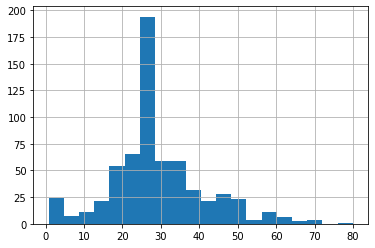

In [13]:
# Age distribution
dftrain.age.hist(bins=20)

<AxesSubplot:>

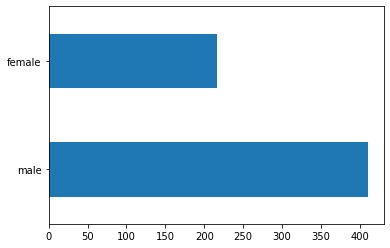

In [14]:
# Gender distribution
dftrain.sex.value_counts().plot(kind="barh")

Text(0.5, 0, '% survive')

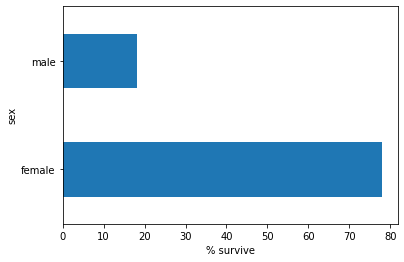

In [15]:
perc_survival = concat([dftrain, y_train], axis=1).groupby("sex").survived.mean() * 100
perc_survival.plot(kind="barh").set_xlabel("% survive")

In [16]:
# Convert categorical data to numeric
categorical_columns = ["sex", "n_siblings_spouses", "parch", "class", "deck", "embark_town", "alone"]
numeric_columns = ["age", "fare"]
feature_columns = []

for feature_name in categorical_columns:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in numeric_columns:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [69]:
# Inspect numeric feature column
age_column = feature_columns[7]
print("Age feature column: \n {}\n".format(tf.keras.layers.DenseFeatures([age_column], dtype=tf.float32)(feature_batch).numpy()))

# Inspect categorical column
gender_column = feature_columns[0]
print("Gender feature column: \n {}\n".format(tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(gender_column)], dtype=tf.float32)(feature_batch).numpy()))

Age feature column: 
 [[49.]
 [ 9.]
 [42.]
 [23.]
 [29.]
 [24.]
 [20.]
 [16.]
 [ 4.]
 [22.]]

Gender feature column: 
 [[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]



In [70]:
# Input function
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
#     Batch of the dataset
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    
    if shuffle:
      ds = ds.shuffle(1000)
    
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    return ds
  return input_function

In [71]:
# Inspect dataset
ds = make_input_fn(dftrain, y_train, batch_size=10)()

for feature_batch, class_batch in ds.take(1):
    print("Feature keys: {} \n".format(list(feature_batch.keys())))
    print("A batch of features: {} \n".format(feature_batch["class"]))
    print("A batch of labels: {} \n".format(class_batch))

Feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone'] 

A batch of features: [b'Second' b'Third' b'Second' b'First' b'Third' b'First' b'Second'
 b'Third' b'First' b'Third'] 

A batch of labels: [0 1 1 1 1 1 0 0 1 0] 



Model accuracy: 0.7537878751754761
Survived: yes
Predicted probablity of survival: 96.38228416442871


<AxesSubplot:title={'center':'predicted probabilities'}, ylabel='Frequency'>

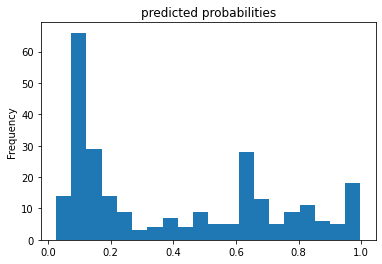

In [116]:
# Train model on base feature columns
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

linear_est.train(train_input_fn)
test_result = linear_est.evaluate(eval_input_fn)

clear_output()

result = list(linear_est.predict(eval_input_fn))
clear_output()
survival_map = {
    0: "no",
    1: "yes"
}

print("Model accuracy: {}".format(test_result["accuracy"]))
print("Survived: {}".format(survival_map[y_eval.loc[70]]))
print("Predicted probablity of survival: {}".format(result[70]["probabilities"][1] * 100))

probability = pd.Series([res['probabilities'][1] for res in result])

probability.plot(kind='hist', bins=20, title='predicted probabilities')

Model accuracy: 0.7651515007019043
Survived: yes
Predicted probablity of survival: 87.15981245040894


<AxesSubplot:title={'center':'predicted probabilities'}, ylabel='Frequency'>

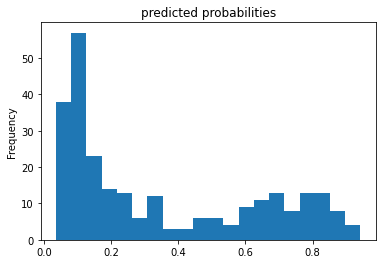

In [104]:
# Train on Derived feature columns
age_x_gender_x_class = tf.feature_column.crossed_column(["age", "sex", "class"], hash_bucket_size=100)
derived_feature_columns = [age_x_gender_x_class]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_columns)

linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

test_result = linear_est.evaluate(eval_input_fn)

clear_output()

result = list(linear_est.predict(eval_input_fn))
clear_output()
survival_map = {
    0: "no",
    1: "yes"
}

print("Model accuracy: {}".format(test_result["accuracy"]))
print("Survived: {}".format(survival_map[y_eval.loc[70]]))
print("Predicted probablity of survival: {}".format(result[70]["probabilities"][1] * 100))

probability = pd.Series([res['probabilities'][1] for res in result])

probability.plot(kind='hist', bins=20, title='predicted probabilities')

(0.0, 1.05)

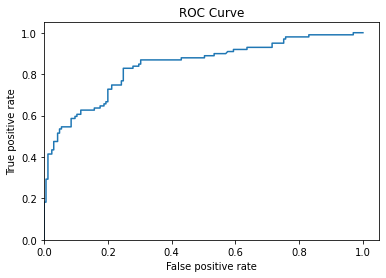

In [114]:
fpr, tpr, _  = roc_curve(y_eval, probability)
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.xlim(0,)
plt.ylim(0,)